# Fine-tuning ResNet18 with PyTorch

To adapt a ResNet18 model for audio classification, we'll use Mel spectrograms as input to represent audio data in a visual format.

Libraries:

1. PyTorch: A popular deep learning framework.
1. TorchAudio: Provides tools for working with audio data in PyTorch.
1. Torchvision: Offers pre-trained models and data transformations.

## Imports

First we create our Dataset from the folders.

In [1]:
import torch
import torchaudio
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torchvision import  models
import librosa
import matplotlib.pyplot as plt
import torchvision


In my case, I will use MPS (mac GPU)

In [2]:
if torch.backends.mps.is_available():
        device = "mps"

else:
    device = "cpu"
print(f"Using device {device}")

Using device mps


Let's list the genres.

In [3]:
import os

def list_subdirectories(directory_path):

    subdirectories = []
    for item in os.listdir(directory_path):
        if os.path.isdir(os.path.join(directory_path, item)):
            subdirectories.append(item)

    return subdirectories

directory_path = "./split_songs_v2/test"
genres = list_subdirectories(directory_path)
print(genres)

['psytrance', 'ukgarage', 'drumbass', 'house', 'dupstep', 'dubtechno', 'hardcore_breaks', 'techno']


In [4]:
label2id, id2label = dict(), dict()

for i, label in enumerate(genres):
    label2id[label] = i
    id2label[i] = label

We'll construct the function to retrieve the labels from the numbers and vice-versa

In [5]:
label2id,id2label

({'psytrance': 0,
  'ukgarage': 1,
  'drumbass': 2,
  'house': 3,
  'dupstep': 4,
  'dubtechno': 5,
  'hardcore_breaks': 6,
  'techno': 7},
 {0: 'psytrance',
  1: 'ukgarage',
  2: 'drumbass',
  3: 'house',
  4: 'dupstep',
  5: 'dubtechno',
  6: 'hardcore_breaks',
  7: 'techno'})

## Dataset Creation

To create a custom dataset for audio classification, we'll define a class inheriting from torch.utils.data.Dataset. The __getitem__ method is crucial for data loading, preprocessing, and applying transformations.

Key Point: After loading and pre-processing the audio data, we convert it to a Mel spectrogram, which is essentially a grayscale image (single channel). Since our model likely expects a three-channel RGB image, we'll need to repeat the Mel spectrogram three times to create a suitable input format.

In [6]:


class GenreDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transformation, num_samples,
                target_sample_rate, device):
        self.root_dir = root_dir
        self.genres = os.listdir(root_dir)
        self.files = {}
        for genre in self.genres:
            self.files[genre] = os.listdir(os.path.join(root_dir, genre))

        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return sum(len(files) for files in self.files.values())

    def __getitem__(self, idx):
        genre = None
        file_idx = 0
        for g, files in self.files.items():
            if idx < len(files):
                genre = g
                file_idx = idx
                break
            else:
                idx -= len(files)
        audio_path = os.path.join(self.root_dir, genre, self.files[genre][file_idx])
        genre = label2id[genre]
        # Load audio file
        signal, sr = torchaudio.load(audio_path, format="mp3")
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        signal = torchaudio.transforms.AmplitudeToDB()(signal).to(device)
        signal = signal.repeat(3, 1, 1)
        signal = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(signal)
        return signal, genre

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(self.device)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal








## Dataset Loading

In [7]:

SAMPLE_RATE = 16000
NUM_SAMPLES = 16000*3
IMAGE_SIZE = 224

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=100,
        normalized = True
    )


transformation = torchvision.transforms.Compose([mel_spectrogram.to(device), torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

We load both train and test

In [8]:
torch_dataset = GenreDataset("./split_songs_v2/train/",
                            # transformations,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device)
torch_dataset_test = GenreDataset("./split_songs_v2/test/",
                            # transformations,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device)

In [9]:
print(f"There are {len(torch_dataset)} samples in the dataset.")



There are 4626 samples in the dataset.


In [10]:
class_counts = {}
for i in range(len(torch_dataset)):
    x, y = torch_dataset[i]
    class_label = id2label[y]
    if class_label not in class_counts:
        class_counts[class_label] = 1
    else:
        class_counts[class_label] += 1
class_counts

{'psytrance': 711,
 'ukgarage': 441,
 'drumbass': 639,
 'house': 576,
 'dupstep': 603,
 'dubtechno': 594,
 'hardcore_breaks': 423,
 'techno': 639}

Let's have a look on one data point.

In [11]:
torch_dataset[0]

(tensor([[[   6.4277,  -25.0862,  -21.1393,  ...,   35.9680,   55.6382,
             18.7808],
          [   0.6965,   16.7566,   41.2985,  ...,   34.5303,   58.9467,
            -16.1761],
          [  52.4051,   53.2355,   59.2268,  ...,   23.7417,   40.5106,
             -3.3456],
          ...,
          [-165.6284, -438.7991, -438.7991,  ..., -436.4384, -435.8509,
           -270.5832],
          [-165.0446, -438.7991, -438.7991,  ..., -438.7991, -438.7991,
           -273.0328],
          [-164.5109, -438.7991, -438.7991,  ..., -438.7991, -438.7991,
           -274.2307]],
 
         [[   6.7006,  -25.5167,  -21.4817,  ...,   36.9004,   57.0096,
             19.3295],
          [   0.8415,   17.2600,   42.3498,  ...,   35.4305,   60.3920,
            -16.4077],
          [  53.7043,   54.5533,   60.6782,  ...,   24.4012,   41.5443,
             -3.2908],
          ...,
          [-169.1960, -448.4643, -448.4643,  ..., -446.0508, -445.4502,
           -276.4935],
          [-168.5

Let's check has the correct dimensions:

In [12]:
torch_dataset[0][0].shape


torch.Size([3, 100, 32])

## Model

To construct the ResNet18 model for audio classification, we'll use the pre-trained model from torchvision and modify the final fully connected layer to match the number of desired output classes.

1. We load the pre-trained ResNet18 model from torchvision.
1. The *fc* attribute represents the final fully connected layer, which is responsible for classification.
1. We replace the existing *fc* layer with a new one that has the desired number of output units (corresponding to the number of genres).

In [13]:
num_classes = len(genres)
num_classes

8

In [14]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

/opt/anaconda3/envs/letstrythis/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/letstrythis/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
BATCH_SIZE = 128

Now we take one step further and split our train dataset into train and validation.

We create then the three different dataloaders.

In [16]:
# Calculate the size of the validation set
val_size = int(len(torch_dataset) * 0.1)

# The rest of the data will be the training data.
train_size = len(torch_dataset) - val_size 

# Split the training data into training and validation sets.
train_ds, val_ds = random_split(torch_dataset, [train_size, val_size])

# Create data loaders for the training, validation, and test sets.
# This will allow us to load data in batches.
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE * 2, num_workers=0, pin_memory=True)
test_dl = DataLoader(torch_dataset_test, BATCH_SIZE * 2, num_workers=0, pin_memory=True)

To gain a closer look into the data we'll be feeding to our model, let's visualize a few Mel spectrograms. This will help us understand the spectral characteristics of the audio data.

In [17]:

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-62.25967..17.74033].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-60.38192..19.618078].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-61.022114..18.977886].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-60.391605..19.608395].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-61.498672..18.501326].


Genre: tensor([2, 0, 4, 0, 2, 3, 2, 1, 6, 3, 0, 1, 0, 1, 1, 0, 5, 1, 5, 3, 2, 4, 7, 5,
        5, 4, 5, 2, 1, 5, 4, 5, 7, 5, 0, 1, 5, 6, 0, 5, 3, 7, 2, 2, 4, 4, 3, 3,
        2, 5, 7, 4, 2, 5, 4, 3, 5, 4, 1, 2, 4, 7, 5, 3, 0, 3, 2, 7, 7, 7, 3, 5,
        5, 2, 4, 2, 7, 6, 7, 7, 7, 3, 3, 5, 7, 5, 2, 2, 0, 6, 0, 3, 6, 0, 3, 5,
        1, 3, 2, 0, 0, 0, 1, 7, 5, 1, 6, 7, 2, 4, 7, 7, 6, 5, 0, 3, 1, 7, 5, 7,
        1, 4, 2, 4, 0, 1, 5, 0])
Genre: tensor([2, 0, 4, 0, 2, 3, 2, 1, 6, 3, 0, 1, 0, 1, 1, 0, 5, 1, 5, 3, 2, 4, 7, 5,
        5, 4, 5, 2, 1, 5, 4, 5, 7, 5, 0, 1, 5, 6, 0, 5, 3, 7, 2, 2, 4, 4, 3, 3,
        2, 5, 7, 4, 2, 5, 4, 3, 5, 4, 1, 2, 4, 7, 5, 3, 0, 3, 2, 7, 7, 7, 3, 5,
        5, 2, 4, 2, 7, 6, 7, 7, 7, 3, 3, 5, 7, 5, 2, 2, 0, 6, 0, 3, 6, 0, 3, 5,
        1, 3, 2, 0, 0, 0, 1, 7, 5, 1, 6, 7, 2, 4, 7, 7, 6, 5, 0, 3, 1, 7, 5, 7,
        1, 4, 2, 4, 0, 1, 5, 0])
Genre: tensor([2, 0, 4, 0, 2, 3, 2, 1, 6, 3, 0, 1, 0, 1, 1, 0, 5, 1, 5, 3, 2, 4, 7, 5,
        5, 4, 5, 2, 1, 5, 4, 5, 7

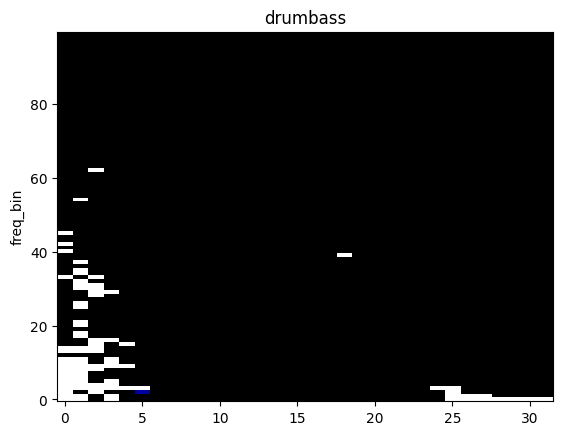

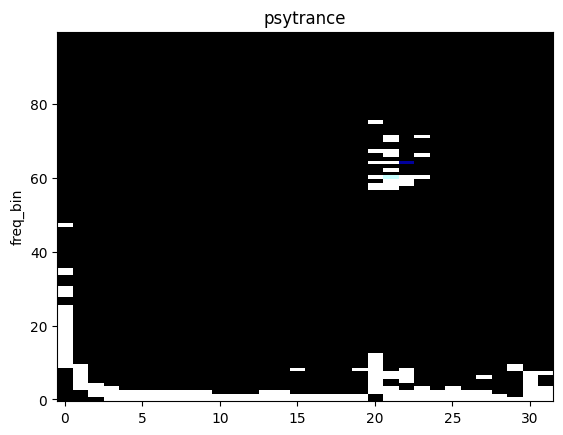

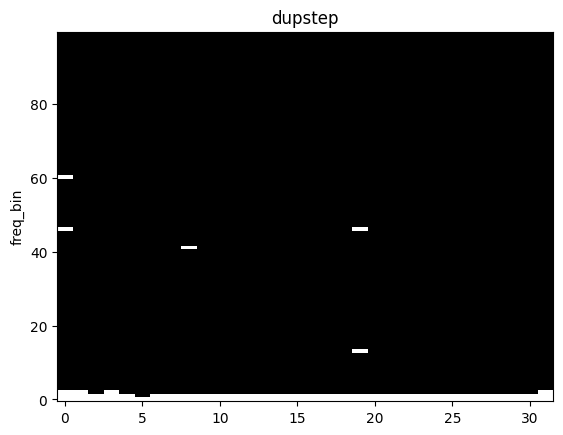

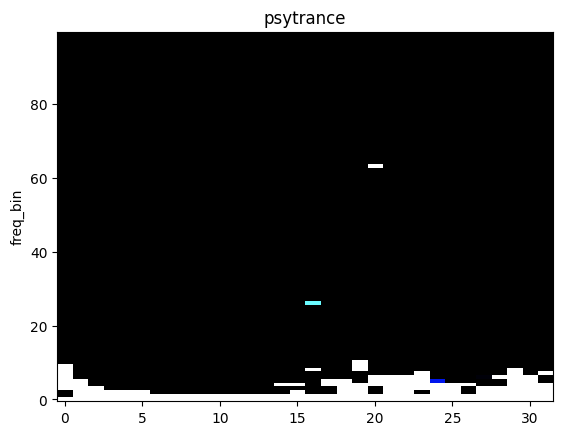

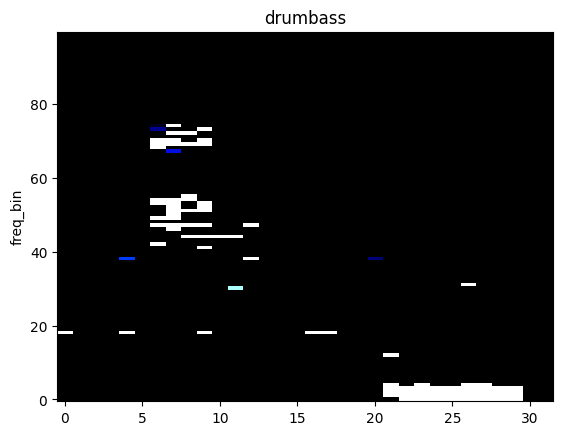

In [18]:
# Iterate over the data loader (or directly over the dataset if not using a data loader)
for data, genre in train_dl:
    # Get the mel spectrogram from the transformed audio

    # Print the mel spectrogram
    for i in range(5):
        plot_spectrogram(data.cpu()[i].permute(1, 2, 0), id2label[genre[i].item()])

        print("Genre:", genre)  # Optionally print the corresponding genre
    break

Well, not very promising right? This is because the three channels are identical, but don't worry, it will work.

In [19]:
dataloaders = {"train" : train_dl, "val":val_dl}

In [20]:
dataset_sizes = {"train" : len(train_ds), "val":len(val_ds)}

In [21]:
dataset_sizes

{'train': 4164, 'val': 462}

To optimize the training process and improve convergence, we'll use the Adam optimizer with a learning rate of 0.001. Additionally, we'll implement a step learning rate scheduler to gradually reduce the learning rate during training.

In [22]:
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.999))
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



In [23]:
#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

## Train loop

Let's define our training loop.

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #For graph generation
            if phase == "train":
                train_loss.append(running_loss/dataset_sizes[phase])
                train_acc.append(running_corrects / dataset_sizes[phase])
                epoch_counter_train.append(epoch)
            if phase == "val":
                val_loss.append(running_loss/ dataset_sizes[phase])
                val_acc.append(running_corrects / dataset_sizes[phase])
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            #for printing        
            if phase == "train":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == "val":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


And now is time to train it!

## Training

In [25]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)


Epoch 1/20
----------


/opt/anaconda3/envs/letstrythis/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 1.3006 Acc: 0.5360
val Loss: 1.4185 Acc: 0.5087

Epoch 2/20
----------
train Loss: 0.7310 Acc: 0.7462
val Loss: 1.1503 Acc: 0.6104

Epoch 3/20
----------
train Loss: 0.4973 Acc: 0.8204
val Loss: 0.9278 Acc: 0.6970

Epoch 4/20
----------
train Loss: 0.3763 Acc: 0.8708
val Loss: 0.7980 Acc: 0.7532

Epoch 5/20
----------
train Loss: 0.2443 Acc: 0.9123
val Loss: 0.9472 Acc: 0.7100

Epoch 6/20
----------
train Loss: 0.2521 Acc: 0.9133
val Loss: 1.1516 Acc: 0.6991

Epoch 7/20
----------
train Loss: 0.1069 Acc: 0.9659
val Loss: 0.5503 Acc: 0.8247

Epoch 8/20
----------
train Loss: 0.0421 Acc: 0.9916
val Loss: 0.5542 Acc: 0.8182

Epoch 9/20
----------
train Loss: 0.0274 Acc: 0.9954
val Loss: 0.5431 Acc: 0.8203

Epoch 10/20
----------
train Loss: 0.0180 Acc: 0.9981
val Loss: 0.5419 Acc: 0.8225

Epoch 11/20
----------
train Loss: 0.0145 Acc: 0.9983
val Loss: 0.5479 Acc: 0.8247

Epoch 12/20
----------
train Loss: 0.0115 Acc: 0.9988
val Loss: 0.5559 Acc: 0.8268

Epoch 13/20
----------


## Visualizations

To gain insights into the model's learning process, we can visualize the training and validation loss and accuracy over epochs. This helps identify trends, potential overfitting or underfitting issues, and make necessary adjustments.

In [26]:
train_acc = [x.to("cpu") for x in train_acc]
val_acc = [x.to("cpu") for x in val_acc]


In [27]:
def plot_history():

    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    # Accuracy subplot
    axs[0].plot(train_acc, c='navy', label="Training Accuracy")
    axs[0].plot(val_acc, c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    # Error subplot
    axs[1].plot(train_loss, c='navy', label="Training Loss")
    axs[1].plot(val_loss, c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

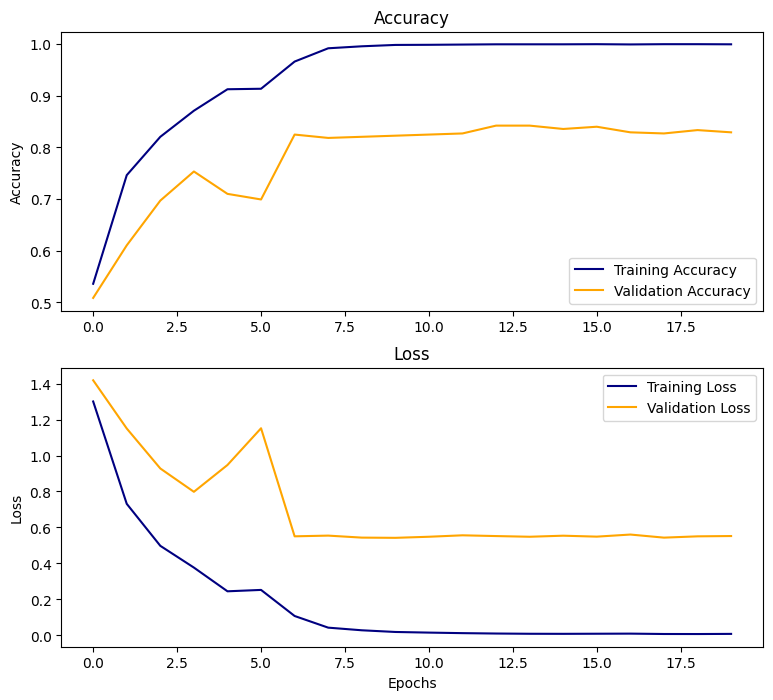

In [28]:
plot_history()

To assess the model's generalization ability and performance on unseen data, we  evaluate it on a separate test dataset that the model hasn't encountered during training.



1. Prediction: Use the trained model to predict the genre for each audio clip in the test dataset.

1. Accuracy: Compute the overall accuracy of the model on the test dataset.

1. Confusion Matrix: By analyzing the confusion matrix, we can identify which genres are frequently confused with others and assess the model's overall performance on each class.


By evaluating the model on new data, we can assess its ability to generalize to unseen examples and identify potential shortcomings that may require further refinement.

In [29]:
import torchmetrics


In [30]:
confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task="multiclass").to(device)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)

with torch.no_grad():
    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted  = torch.max(outputs, 1)

        confusion_matrix.update(predicted, labels)
        accuracy.update(predicted, labels)

cm = confusion_matrix.compute()
acc = accuracy.compute()


In [31]:
print(f"The accuracy on the test data is: {acc}")

The accuracy on the test data is: 0.6912637948989868


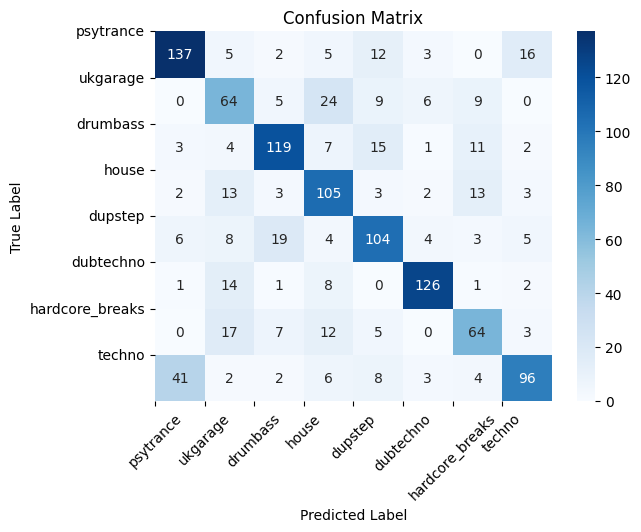

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm.to("cpu"), annot=True, fmt=".0f", cmap="Blues")

# Set labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Add genre labels to ticks
plt.xticks(range(len(id2label)), list(id2label.values()), rotation=45)
plt.yticks(range(len(id2label)), list(id2label.values()), rotation=0)

plt.show()

Well, over all, not bad for the first attemp! We see that it makes some confusions between psytrance and techno and between uk garage and house.